<a href="https://colab.research.google.com/github/olga-terekhova/weather-co2/blob/main/model/Olga_Terekhova_Weather_CO2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CO2 Analysis

We will be exploring relationships of various metrics (weather, time and date) and the CO2 measurement in an apartment. 

In [1]:
# Importing relevant Python packages
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split  
from sklearn.linear_model import LinearRegression 
from sklearn import metrics
import matplotlib.pyplot as plt 


## 1. Importing datasets

### 1.1. Importing a dataset with daily outside weather

In [2]:
# Importing data with outside weather - the dataset is hosted on GitHub
url =  'https://raw.githubusercontent.com/olga-terekhova/weather-co2/main/data/weatherstats_toronto_daily.csv'

# Reading into a Pandas dataframe
df_outside = pd.read_csv(url, sep = ",")

# Printing first several rows of the dataset:
df_outside.head()

,date,max_temperature,avg_hourly_temperature,avg_temperature,min_temperature,max_humidex,min_windchill,max_relative_humidity,avg_hourly_relative_humidity,avg_relative_humidity,...,avg_cloud_cover_4,min_cloud_cover_4,max_cloud_cover_8,avg_hourly_cloud_cover_8,avg_cloud_cover_8,min_cloud_cover_8,max_cloud_cover_10,avg_hourly_cloud_cover_10,avg_cloud_cover_10,min_cloud_cover_10
0,2022-04-11,12.5,6.43,7.00,1.5,NaN,NaN,91,66.8,67.5,...,NaN,NaN,8,5.5,4.5,1,NaN,NaN,NaN,NaN
1,2022-04-10,9.4,4.10,5.00,0.6,NaN,NaN,78,60.5,61.0,...,NaN,NaN,8,6.0,4.5,1,NaN,NaN,NaN,NaN
2,2022-04-09,7.8,3.98,4.45,1.1,NaN,NaN,93,75.9,74.5,...,NaN,NaN,8,6.6,5.5,3,NaN,NaN,NaN,NaN
3,2022-04-08,9.7,5.98,6.10,2.5,NaN,NaN,100,75.9,76.5,...,NaN,NaN,7,5.6,4.0,1,NaN,NaN,NaN,NaN
4,2022-04-07,13.8,9.00,9.40,5.0,NaN,NaN,100,85.8,79.0,...,NaN,NaN,8,6.4,5.5,3,NaN,NaN,NaN,NaN


This dataset has data on weather in Toronto during last 1000 days aggregated to daily measurements. 

#### 1.1.1. Preprocessing the dataset with the outdoor weather

In [3]:
# Keeping only relevant columns (daily averages built on hourly measurements)
df_outside = df_outside[['date','avg_hourly_temperature',
         'avg_hourly_relative_humidity','avg_hourly_dew_point', 
         'avg_hourly_wind_speed',
         'avg_hourly_pressure_station',
         'avg_hourly_health_index', 'precipitation']]

# Checking for empty values
print(df_outside.isnull().sum())

# Dropping records with empty values
df_outside = df_outside[df_outside['precipitation'].notnull()]
df_outside.isnull().sum()

date                            0
avg_hourly_temperature          0
avg_hourly_relative_humidity    0
avg_hourly_dew_point            0
avg_hourly_wind_speed           0
avg_hourly_pressure_station     0
avg_hourly_health_index         0
precipitation                   5
dtype: int64


date                            0
avg_hourly_temperature          0
avg_hourly_relative_humidity    0
avg_hourly_dew_point            0
avg_hourly_wind_speed           0
avg_hourly_pressure_station     0
avg_hourly_health_index         0
precipitation                   0
dtype: int64

### 1.2. Importing a dataset with indoor measurements

In [4]:
# Importing data with indoor metrics - the dataset is hosted on GitHub

url = 'https://raw.githubusercontent.com/olga-terekhova/weather-co2/main/data/indoor_stats_hourly.csv'
df_inside = pd.read_csv(url, sep = ",")

# Printing first several rows of the dataset
df_inside.head()

,Unnamed: 0,date,hour,avg_indoor_co2,avg_indoor_temp,avg_indoor_humidity
0,0,2021-03-15,5,675.491588,26.064010,34.457867
1,1,2021-03-15,6,689.492172,25.976376,35.568939
2,2,2021-03-15,7,690.564899,25.787121,34.767500
3,3,2021-03-15,8,658.301389,25.615745,33.327210
4,4,2021-03-15,9,639.362121,25.502324,32.409646


This dataset has a log of measurements for CO2, humidity and temperature in an apartment in Toronto for a range of days between March 2021 and April 2022. Aggregated to hourly measurements. 

#### 1.2.1. Preprocessing the dataset with indoor measurements

In [5]:
# Checking for empty values
print(df_inside.isnull().sum())

# Renaming some columns
df_inside = df_inside.rename(columns={"Date":"date","avg_indoor_temp":"avg_indoor_temperature"})

# Creating a column 'month' derived from date
df_inside = df_inside.assign(month=lambda x: x.date.str.slice(5, 7).astype(int)) #2012-12-01

# Creating a column 'dayofweek' derived from date (0 - Monday, ..., 6 - Sunday)
df_inside = df_inside.assign(dayofweek=lambda x: pd.to_datetime(x.date).dt.dayofweek) 

# Printing several first rows of the expanded dataset
df_inside.head()



Unnamed: 0             0
date                   0
hour                   0
avg_indoor_co2         0
avg_indoor_temp        0
avg_indoor_humidity    0
dtype: int64


,Unnamed: 0,date,hour,avg_indoor_co2,avg_indoor_temperature,avg_indoor_humidity,month,dayofweek
0,0,2021-03-15,5,675.491588,26.064010,34.457867,3,0
1,1,2021-03-15,6,689.492172,25.976376,35.568939,3,0
2,2,2021-03-15,7,690.564899,25.787121,34.767500,3,0
3,3,2021-03-15,8,658.301389,25.615745,33.327210,3,0
4,4,2021-03-15,9,639.362121,25.502324,32.409646,3,0


### 1.3. Merging two source datasets into one single dataset

In [6]:
# Merging two datasets together using the common attribute 'data'. 
# That leaves only rows with the same range of dates.

df_result = pd.merge(df_inside,df_outside,on = ['date'])

# Printing first 10 rows of the resulting dataset
print(df_result.head(10))

   Unnamed: 0        date  hour  avg_indoor_co2  avg_indoor_temperature  \
0           0  2021-03-15     5      675.491588               26.064010   
1           1  2021-03-15     6      689.492172               25.976376   
2           2  2021-03-15     7      690.564899               25.787121   
3           3  2021-03-15     8      658.301389               25.615745   
4           4  2021-03-15     9      639.362121               25.502324   
5           5  2021-03-15    10      618.087500               25.455833   
6           6  2021-03-15    11      605.772601               25.782472   
7           7  2021-03-15    12      605.279526               26.071247   
8           8  2021-03-15    13      578.753056               26.394676   
9           9  2021-03-15    14      576.787325               26.653472   

   avg_indoor_humidity  month  dayofweek  avg_hourly_temperature  \
0            34.457867      3          0                   -4.79   
1            35.568939      3         

## 2. Exploratory data analysis

In [7]:
# Print out the number of rows and columns in the dataset
print("Dimensionality of the DataFrame:", df_result.shape)

Dimensionality of the DataFrame: (9140, 15)


In [8]:
# Print out summary statistics for each variable in the dataset
df_result.describe()

,Unnamed: 0,hour,avg_indoor_co2,avg_indoor_temperature,avg_indoor_humidity,month,dayofweek,avg_hourly_temperature,avg_hourly_relative_humidity,avg_hourly_dew_point,avg_hourly_wind_speed,avg_hourly_pressure_station,avg_hourly_health_index,precipitation
count,9140.000000,9140.000000,9140.000000,9140.000000,9140.000000,9140.000000,9140.000000,9140.000000,9140.000000,9140.000000,9140.000000,9140.000000,9140.000000,9140.000000
mean,4603.140481,11.484136,586.375703,26.613744,48.387386,6.278337,2.983589,9.540185,68.952691,3.583928,15.749817,99.508389,2.591422,2.444179
std,2660.835083,6.921904,79.472576,0.868568,13.737207,3.402623,1.987034,10.628786,13.644356,10.481103,6.315768,0.667140,0.632072,6.168528
min,0.000000,0.000000,315.713535,23.309432,24.238851,1.000000,0.000000,-17.550000,29.700000,-26.500000,6.420000,97.330000,1.200000,0.000000
25%,2284.750000,5.000000,532.569842,25.994975,37.093374,3.000000,1.000000,1.350000,61.600000,-3.700000,10.750000,99.120000,2.100000,0.000000
50%,4617.500000,11.000000,584.010480,26.558333,44.622734,6.000000,3.000000,9.000000,68.900000,3.000000,14.460000,99.460000,2.500000,0.000000
75%,6902.250000,17.000000,636.718548,27.166280,61.292298,9.000000,5.000000,19.220000,76.800000,12.900000,19.380000,99.920000,3.000000,1.800000
max,9201.000000,23.000000,1095.733977,32.636571,83.737386,12.000000,6.000000,27.500000,100.000000,21.900000,39.120000,101.500000,4.500000,56.000000


In [9]:
# Print out the data type of each feature in the dataset
print("Data type of each feature:")
df_result.dtypes

Data type of each feature:


Unnamed: 0                        int64
date                             object
hour                              int64
avg_indoor_co2                  float64
avg_indoor_temperature          float64
avg_indoor_humidity             float64
month                             int64
dayofweek                         int64
avg_hourly_temperature          float64
avg_hourly_relative_humidity    float64
avg_hourly_dew_point            float64
avg_hourly_wind_speed           float64
avg_hourly_pressure_station     float64
avg_hourly_health_index         float64
precipitation                   float64
dtype: object

In [10]:
# Determine if there are any missing datapoints or duplicate rows in the dataset
print("\nAre there any missing datapoints in the dataset?", df_result.isnull().values.any())
print("Number of duplicated rows:", df_result.duplicated().sum())


Are there any missing datapoints in the dataset? False
Number of duplicated rows: 0


No missing datapoints and no duplicates.

### 2.1. Data visualization

#### 2.1.1. Checking for normal distribution

/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(0.9872538447380066, 7.4846211722505905e-28)


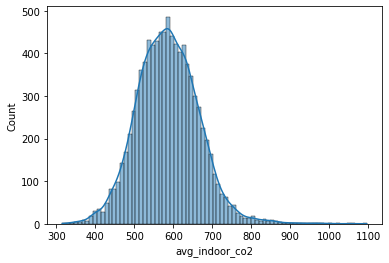

In [11]:
# Checking the distribution of indoor CO2 (target variable)

sns.histplot(df_result['avg_indoor_co2'], kde=True)
print(stats.shapiro(df_result['avg_indoor_co2']));

Indoor CO2 measurements conform to normal distribution, so no need to transform this variable to satisfy linear regression conditions.

The distribution also shows that current airflow management in this unit is quite good, as the mean is a little bit under 600 and measurements rarely creep up into high numbers.

#### 2.1.2. Checking multicolinearity of independent variables

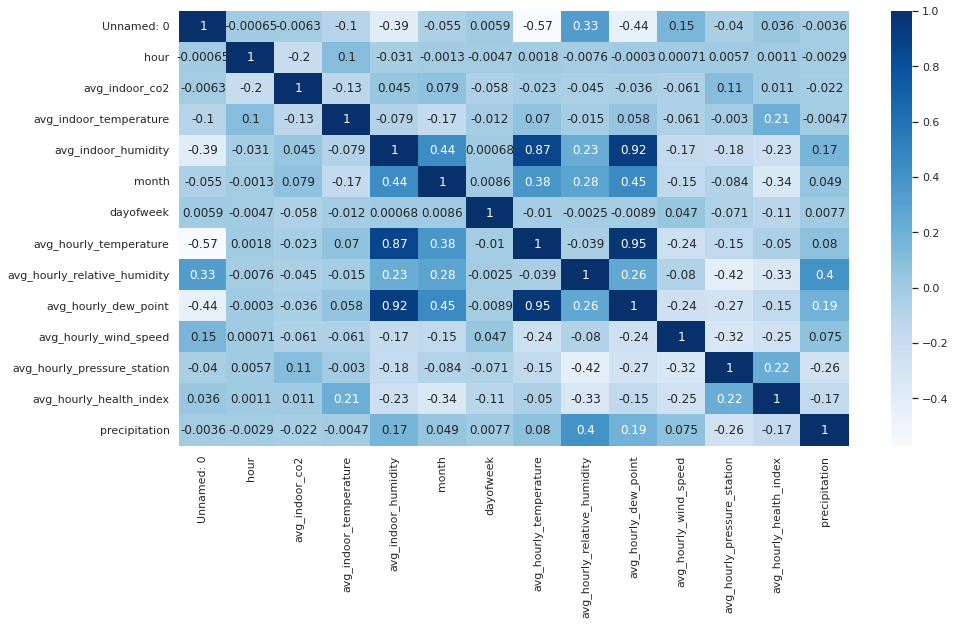

In [12]:
# Check correlations using plotting a heat map of correlations:
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(df_result.corr(), cmap='Blues', annot=True);

There are several correlated independent variables. 
We'll drop columns 'avg_indoor_humidity', 'precipitation', 'avg_hourly_dew_point' and check for correlations again. 

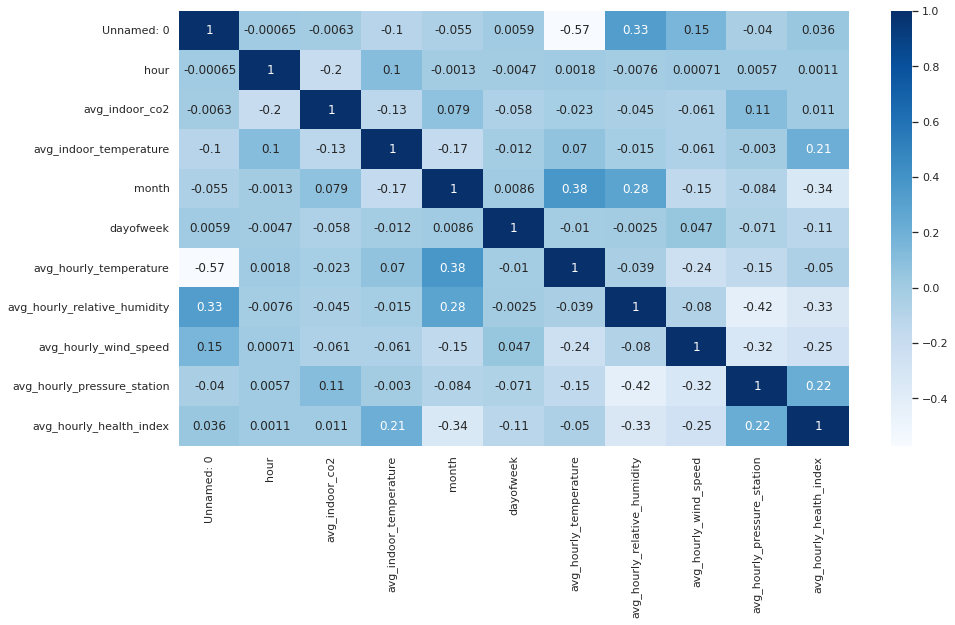

In [13]:
# Removing  'avg_indoor_humidity', 'precipitation', 'avg_hourly_dew_point'
df_result = df_result.drop(columns=['avg_indoor_humidity','precipitation','avg_hourly_dew_point'])

# Plotting the heatmap again
sns.heatmap(df_result.corr(), cmap='Blues', annot=True);

Now the independent variables are not correlated.
When we check for correlations with the target variable 'avg_indoor_co2', there are not strong correlations either, so we suspect the selected independent variables will not have a lot of explanatory power in the final linear regression model. 

#### 2.1.3. Visualizing independent variables

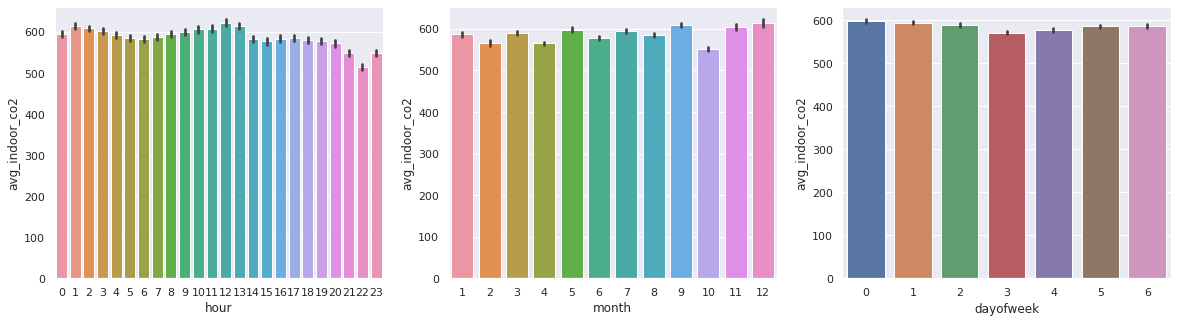

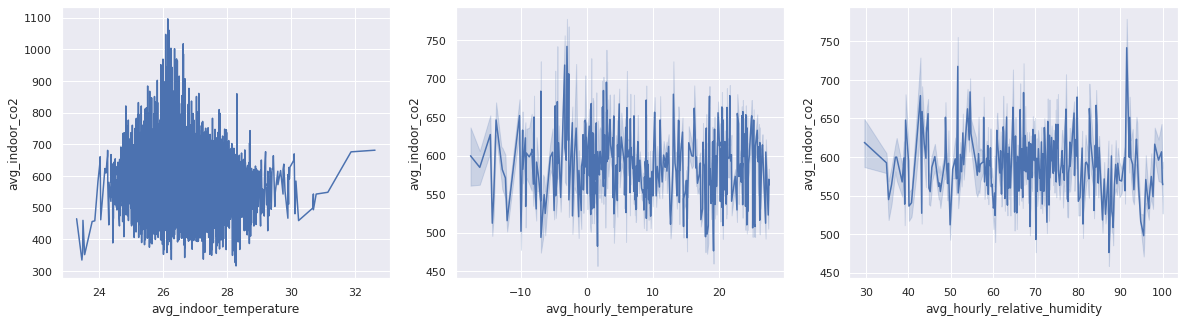

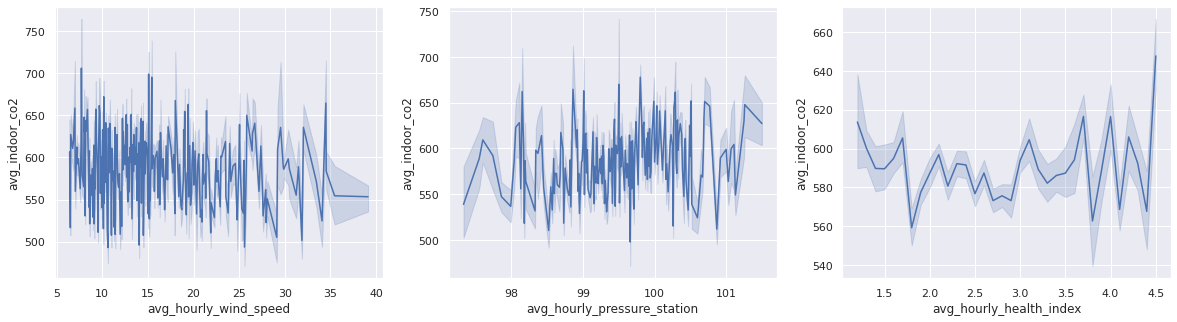

In [14]:
# Plot the relationship between the independent variables (hour, 
# avg_hourly_pressure_station, avg_indoor_temperature, month, day of week,
# and the dependent/target variable (indoor co2)
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(20,5))
sns.barplot(x='hour', y='avg_indoor_co2', data=df_result, ax=ax0);
sns.barplot(x='month', y='avg_indoor_co2', data=df_result, ax=ax1);
sns.barplot(x='dayofweek', y='avg_indoor_co2', data=df_result, ax=ax2);


fig, (ax3, ax4, ax5) = plt.subplots(1, 3, figsize=(20,5))
sns.lineplot(x='avg_indoor_temperature', y='avg_indoor_co2', data=df_result, ax=ax3);
sns.lineplot(x='avg_hourly_temperature', y='avg_indoor_co2', data=df_result, ax=ax4);
sns.lineplot(x='avg_hourly_relative_humidity', y='avg_indoor_co2', data=df_result, ax=ax5);

fig, (ax6, ax7, ax8) = plt.subplots(1, 3, figsize=(20,5))
sns.lineplot(x='avg_hourly_wind_speed', y='avg_indoor_co2', data=df_result, ax=ax6);
sns.lineplot(x='avg_hourly_pressure_station', y='avg_indoor_co2', data=df_result, ax=ax7);
sns.lineplot(x='avg_hourly_health_index', y='avg_indoor_co2', data=df_result, ax=ax8);

It appears there are some trends for the 3 categorical variables derived from date/time:
- CO2 seems to be lower in the evening - probably due to the fact that inhabitants are often out in the evening, they manage CO2 better when they are not working, and they air the unit before sleep. 
- CO2 seems to be the lowest in October, and highest in September and January. As only around one year of data is observed, this observation is not very reliable. For longer spans it might have been a consequence of heating or cooling in the apartment, as people usually leave smaller cracks in extreme cold or extreme heat. 
- CO2 seems to be the lowest on Thursday and the highest on Monday. This observation is puzzling and there is a need in more hypotheses that could try explaining that. 

It's hard to glean any meaningful insights for the 6 continuous variables, except for the slight correlation between indoor CO2 and air pressure (0.11 according to the heatmap above). 

There is an interesting observation for indoor temperature and CO2. As the thermostat is set at around 23 degrees, the values higher than that might mean that there's a cool pocket at the thermostat and the ventilation in the unit doesn't bring the temperature to the same level. When the measured temperature is close to the target 23 degrees, CO2 is also lower, which might mean that better ventilation in the unit mixes indoor air better, both decreasing CO2 and indoor temperature.

## 3. Preprocessing

As all independent variables and the target variables are already numerical, there's no need for additional encoding.

## 4. Modelling

### 4.1. Create train and test datasets

In [15]:
# Defining X (features) and y (target)

X = df_result[['hour','month','dayofweek','avg_indoor_temperature', 'avg_hourly_temperature', 'avg_hourly_relative_humidity',
               'avg_hourly_wind_speed', 'avg_hourly_pressure_station', 'avg_hourly_health_index']]

y = df_result['avg_indoor_co2']
X.head()

# Spliting the dataset into X_train, X_test, y_train, and y_test
# Retaining 10% of the data for testing, and use a random state value of "0"
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

### 4.2. Linear regression

We will build a linear regression model to predict indoor CO2 measurments based on hour, month, day of the week, indoor and outdoor temperature, outdoor humidity, wind speed, pressure and health index.

#### 4.2.1. Build the model

In [16]:
# Instantiate a linear regression model
linear_model = LinearRegression() 

# Fit the model using the training data
linear_model.fit(X_train, y_train) 

# Print out the intercept and coefficients for the linear regression model
print(linear_model.intercept_)
print(linear_model.coef_)

104.53648637373817
[-2.16967867  2.46971077 -2.0226479  -8.40347034 -0.38531855 -0.31728482
 -0.4919888   7.52656797  1.88798216]


#### 4.2.2. Make predictions

In [17]:
# For each record in the test set, make a prediction for the y value (transformed value of charges)
# The predicted values are stored in the y_pred array
y_pred = linear_model.predict(X_test)

#### 4.2.3. Model evaluation

In [18]:
# Metrics


MSE = (1 / len(y_test)) * sum ((y_test - y_pred)**2)
MAE = (1 / len(y_test)) * sum (abs(y_test - y_pred))
RSS = sum ((y_test - y_pred)**2)
TSS = sum ((y_test - y_test.mean())**2)
R_squared = 1 - (RSS/TSS)

print("\n")
print("Mean squared error (MSE) =", MSE)
print("Mean absolute error (MAE) =", MAE)
print("R^2 =", R_squared)

# The metrics package in Python can derive the model evaluation metrics
print("Mean squared error (MSE) =", metrics.mean_squared_error(y_test, y_pred))
print("Mean absolute error (MAE) =", metrics.mean_absolute_error(y_test, y_pred))
print("R^2 =", metrics.r2_score(y_test, y_pred))



Mean squared error (MSE) = 6108.852664547078
Mean absolute error (MAE) = 60.59873346368757
R^2 = 0.07732684476711205
Mean squared error (MSE) = 6108.852664547086
Mean absolute error (MAE) = 60.59873346368753
R^2 = 0.07732684476711105


R squared at 7.7% shows that the model has very little predictive power. 

It might mean that outdoor weather doesn't influence the concentration of CO2 much. The factors outside the model, like the number of CO2 producing inhabitants in the unit and the patterns of managing airflow via window cracks and building ventilation might have more weight. It could also mean that the data is not linearly separable. 

### 4.3. Decision Tree

Next we'll try using a single decision tree, hoping for high interpretability of the results.
As we're trying to predict a continuous variable, we need to use a regression decision tree. 

#### 4.3.1 Build the model

In [19]:
# Importing packages for Decison Tree Regressor

from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

The function to score the model should be changed from accuracy (suitable for classification tasks) to R squared (suitable for regression tasks).

In [20]:
def get_acc(model, X, t):
    # 1. Get a vector of predicted results
    y_pred = model.predict(X) # uses tree.predict method

    # 2. Get a vector of actual labels - t

    # 3. acc = R squared
    acc = metrics.r2_score(t, y_pred)
    return acc

In [21]:
def select_model(depths,  criterion ):
    out = {}
    for d in depths:
        print('Evaluating on depth {}'.format(d))
        out[d] = {}
        tree = DecisionTreeRegressor(max_depth = d,criterion = criterion) 
        tree.fit(X_train, y_train)  

        out[d]['test'] = get_acc(tree, X_test, y_test) # data['val'] is a tuple where 0 is array of data points, 1 is a vector of labels
        out[d]['train'] = get_acc(tree, X_train, y_train)
        out[d]['model'] = tree
    return out

#### 4.3.2. Make predictions and evaluate models

In [22]:
depths = [2,5,8,9,10,15,20,30,50,70] # the depths you want to explore go in the depths list   # EDITED 

res_sq_error = select_model(depths, "squared_error") # training models with different depths using information gain
# looping over the different models and accuracies to find the optimal model according to its validation accuracy
best_d_sq_error = None
best_acc_sq_error = 0

for d in res_sq_error:
    test_acc = res_sq_error[d]['test']
    print("Depth: {}   Train: {}    Test: {}".format(d, res_sq_error[d]['train'], test_acc))
    if test_acc  > best_acc_sq_error:
        best_d_sq_error = d
        best_acc_sq_error = test_acc

print('Best d (sq_error): ' + str(best_d_sq_error))
print('Best accuracy (sq_error): ' + str(best_acc_sq_error))
# train the models with the gini impurity criterion 

#res_gini = select_model(depths, "gini") # training models with different depths using gini impurity 

# looping over the different models and accuracies to find the optimal model according to its validation accuracy
#best_d_gini = None
#best_acc_gini = 0

#for d in res_gini:
#    test_acc = res_gini[d]['test']
#    print("Depth: {}   Train: {}    Val: {}".format(d, res_gini[d]['train'], test_acc))
#    if test_acc  > best_acc_gini:
#        best_d_gini = d
#        best_acc_gini = test_acc

#print('Best d (gini): ' + str(best_d_gini))
#print('Best accuracy (gini): ' + str(best_acc_gini))

Evaluating on depth 2
Evaluating on depth 5
Evaluating on depth 8
Evaluating on depth 9
Evaluating on depth 10
Evaluating on depth 15
Evaluating on depth 20
Evaluating on depth 30
Evaluating on depth 50
Evaluating on depth 70
Depth: 2   Train: 0.0814904846255331    Test: 0.07268540404816348
Depth: 5   Train: 0.1754560326744553    Test: 0.12489837179163898
Depth: 8   Train: 0.3583563381479895    Test: 0.21289735323202852
Depth: 9   Train: 0.431027264354957    Test: 0.2630530441523481
Depth: 10   Train: 0.5021376536520191    Test: 0.29474131050206576
Depth: 15   Train: 0.8360287533287805    Test: 0.40287681080493576
Depth: 20   Train: 0.9721556086386541    Test: 0.3955088125549703
Depth: 30   Train: 0.9999897345064863    Test: 0.36301989566779413
Depth: 50   Train: 1.0    Test: 0.3791794282631986
Depth: 70   Train: 1.0    Test: 0.4008570964053886
Best d (sq_error): 15
Best accuracy (sq_error): 0.40287681080493576


In [23]:
#get_acc(res_gini[best_d_gini]['model'], X_test, y_test)

#### 4.3.3. Visualize the model

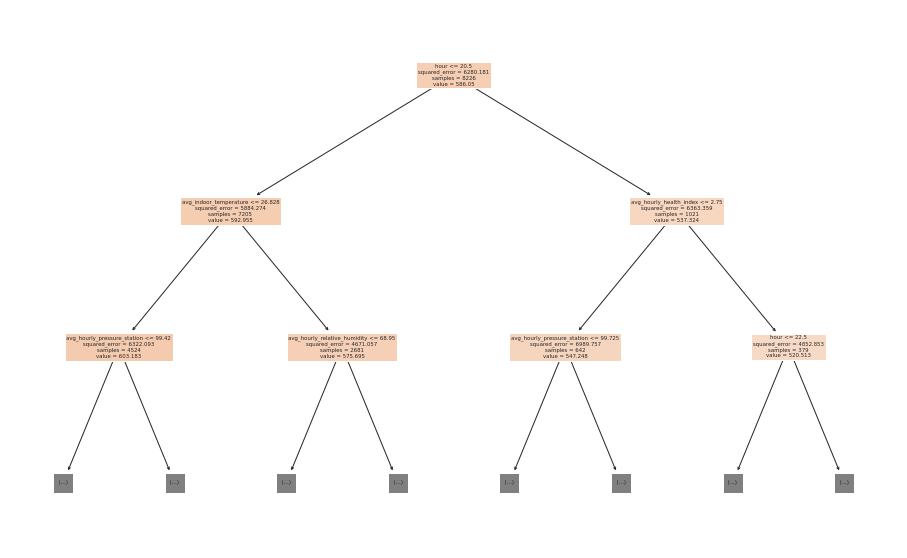

In [24]:
plt.figure(figsize=(16, 10))
#tree.plot_tree(res_gini[best_d_gini]['model'], max_depth = 2, feature_names = feature_names, filled = True, class_names=['fake','real'])
tree.plot_tree(res_sq_error[best_d_sq_error]['model'], max_depth = 2, feature_names = X.columns, filled = True)

plt.show()

### 4.4. Random Forest



Next we'll try using Random Forest tree hoping for better predictable power in exchange for interpretability.

#### 4.4.1. Build the model

In [25]:
# import Python packages

from sklearn.ensemble import RandomForestRegressor

In [26]:
def select_model_random_forest(depths,  criterion ):
    out = {}
    for d in depths:
        print('Evaluating on depth {}'.format(d))
        out[d] = {}
        regr = RandomForestRegressor(max_depth= d, random_state=0, criterion = criterion)
        regr.fit(X_train, y_train)  

        out[d]['test'] = get_acc(regr, X_test, y_test) # data['val'] is a tuple where 0 is array of data points, 1 is a vector of labels
        out[d]['train'] = get_acc(regr, X_train, y_train)
        out[d]['model'] = regr
    return out

#### 4.4.2. Make predictions and evaluate models

In [27]:
depths = [2,5,8,9,10,15,20,30,50,70] # the depths you want to explore go in the depths list   # EDITED 

res_sq_error = select_model_random_forest(depths, "squared_error") # training models with different depths using information gain
# looping over the different models and accuracies to find the optimal model according to its validation accuracy
best_d_sq_error = None
best_acc_sq_error = 0

for d in res_sq_error:
    test_acc = res_sq_error[d]['test']
    print("Depth: {}   Train: {}    Test: {}".format(d, res_sq_error[d]['train'], test_acc))
    if test_acc  > best_acc_sq_error:
        best_d_sq_error = d
        best_acc_sq_error = test_acc

print('Best d (sq_error): ' + str(best_d_sq_error))
print('Best accuracy (sq_error): ' + str(best_acc_sq_error))

Evaluating on depth 2
Evaluating on depth 5
Evaluating on depth 8
Evaluating on depth 9
Evaluating on depth 10
Evaluating on depth 15
Evaluating on depth 20
Evaluating on depth 30
Evaluating on depth 50
Evaluating on depth 70
Depth: 2   Train: 0.08714073184870674    Test: 0.0829893345696825
Depth: 5   Train: 0.23383892805990758    Test: 0.19690102129499854
Depth: 8   Train: 0.48474041436239934    Test: 0.37672018972733257
Depth: 9   Train: 0.5730503964878881    Test: 0.43834595246678376
Depth: 10   Train: 0.6542167421426746    Test: 0.49743913982938304
Depth: 15   Train: 0.8971858901355239    Test: 0.6520403476338261
Depth: 20   Train: 0.9477376963122088    Test: 0.6808803830411541
Depth: 30   Train: 0.9535059785668947    Test: 0.6846544917436655
Depth: 50   Train: 0.9534790933359802    Test: 0.6829058598351887
Depth: 70   Train: 0.9534790933359802    Test: 0.6829058598351887
Best d (sq_error): 30
Best accuracy (sq_error): 0.6846544917436655


#### 4.4.3. Visualize the model

In [28]:
importances = res_sq_error[best_d_sq_error]['model'].feature_importances_
forest_model = res_sq_error[best_d_sq_error]['model']

forest_importances = pd.Series(importances, index=X.columns)
print(forest_importances)

hour                            0.227742
month                           0.051872
dayofweek                       0.047925
avg_indoor_temperature          0.200221
avg_hourly_temperature          0.121358
avg_hourly_relative_humidity    0.098496
avg_hourly_wind_speed           0.093765
avg_hourly_pressure_station     0.096679
avg_hourly_health_index         0.061941
dtype: float64


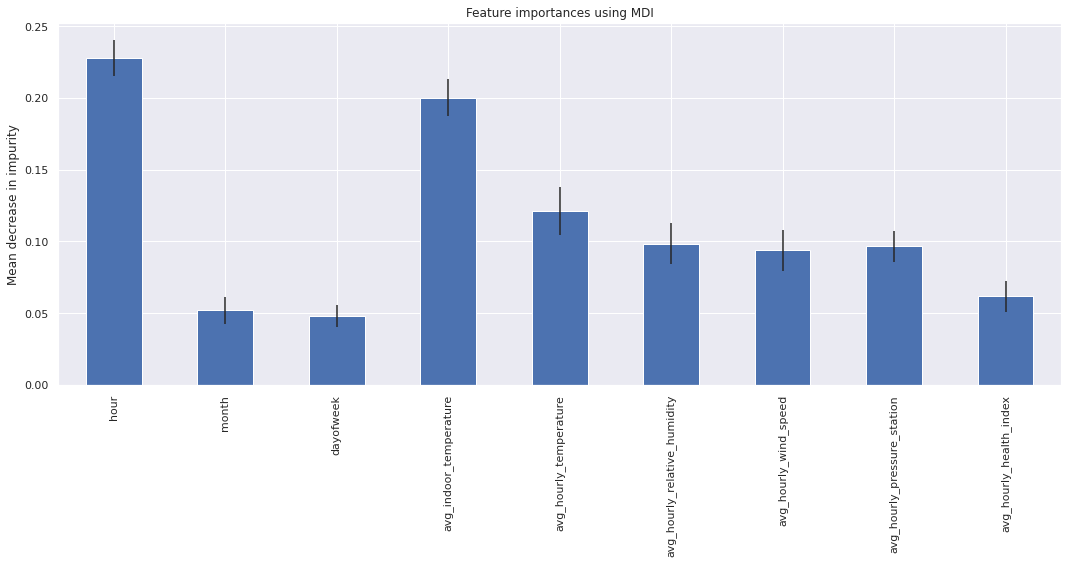

In [29]:
# plotting feature importances

std = np.std([tree.feature_importances_ for tree in forest_model.estimators_], axis=0)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

### 4.5. Neural networks

#### 4.5.1. Build the model

In [30]:
# Importing Python packages

import tensorflow as tf

In [31]:
class NN_Model:
  def __init__(self, I, H, learning_rate, act_function, display, N_epochs, batch_size):
    self.I = I #number of input neurons
    self.H = H
    # self.mag_noise = mag_noise
    self.learning_rate = learning_rate
    self.act_function = act_function
    self.display = display
    self.N_epochs = N_epochs
    self.batch_size = batch_size

    self.epoch_list    = []
    self.cost_training = []
    self.acc_training  = []

NN_Model_1 = NN_Model(9, 72, 0.01, 'relu', True, 10, 64)  # 72, 36
#NN_Model_1 = NN_Model(9, 9, 0.01, 'relu', True, 10, 64)

In [32]:
def define_architecture(self):
  input_size = self.I
  output_size = 1
  hidden_size = self.H
  act_function = self.act_function
  learning_rate = self.learning_rate

  input_layer = tf.keras.Input(shape = (self.I))
  net = tf.keras.layers.Dense(self.H, activation='relu')(input_layer)
  net = tf.keras.layers.Dropout(0.2)(net)
  net = tf.keras.layers.Dense(36, activation='relu')(net)
  net = tf.keras.layers.Dropout(0.2)(net)
  out = tf.keras.layers.Dense(1, activation='linear')(net)

  self.model = tf.keras.models.Model(inputs=input_layer, outputs=out)

  msle = tf.keras.losses.MeanSquaredLogarithmicError()
  self.model.compile(
    loss=msle, 
    optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate), 
    metrics=[msle]
    )
  


NN_Model.define_architecture = define_architecture
NN_Model_1.define_architecture()

Epoch 1/10
103/103 [==============================] - 2s 8ms/step - loss: 0.7831 - mean_squared_logarithmic_error: 0.7818 - val_loss: 0.0238 - val_mean_squared_logarithmic_error: 0.0238
Epoch 2/10
103/103 [==============================] - 0s 3ms/step - loss: 0.0595 - mean_squared_logarithmic_error: 0.0595 - val_loss: 0.0222 - val_mean_squared_logarithmic_error: 0.0223
Epoch 3/10
103/103 [==============================] - 0s 3ms/step - loss: 0.0552 - mean_squared_logarithmic_error: 0.0552 - val_loss: 0.0205 - val_mean_squared_logarithmic_error: 0.0205
Epoch 4/10
103/103 [==============================] - 0s 4ms/step - loss: 0.0512 - mean_squared_logarithmic_error: 0.0512 - val_loss: 0.0191 - val_mean_squared_logarithmic_error: 0.0191
Epoch 5/10
103/103 [==============================] - 0s 3ms/step - loss: 0.0500 - mean_squared_logarithmic_error: 0.0500 - val_loss: 0.0182 - val_mean_squared_logarithmic_error: 0.0183
Epoch 6/10
103/103 [==============================] - 0s 4ms/step - lo

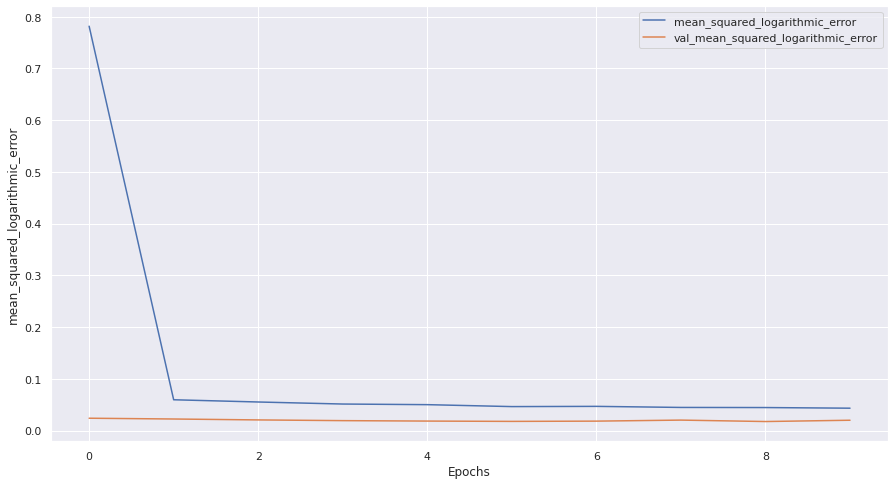

In [33]:
def train_model(self):
  self.history = self.model.fit(
    X_train, 
    y_train, 
    epochs=self.N_epochs, 
    batch_size=self.batch_size,
    validation_split=0.2
  )

def plot_history(self, key):
  plt.plot(self.history.history[key])
  plt.plot(self.history.history['val_'+key])
  plt.xlabel("Epochs")
  plt.ylabel(key)
  plt.legend([key, 'val_'+key])
  plt.show()

NN_Model.train_model = train_model
NN_Model.plot_history = plot_history

NN_Model_1.train_model()
NN_Model_1.plot_history('mean_squared_logarithmic_error')

#### 4.5.2. Make predictions and evaluate models

In [34]:
def predict_model(self):
  self.y_predicted = self.model.predict(X_test)

NN_Model.predict_model = predict_model
NN_Model_1.predict_model()

In [35]:
print(metrics.r2_score(y_test, NN_Model_1.y_predicted))

-0.017843159060373814


### 4.6. Nearest Neighbours

In [36]:
# importing Python packages 
from sklearn.neighbors import KNeighborsRegressor


#### 4.6.1. Build the model

In [38]:
class Neigh_Model:
  def __init__(self, K):
    self.K = K
    self.model = KNeighborsRegressor(n_neighbors=self.K)
  def train(self, X_train, y_train):
    self.model.fit(X_train, y_train)

neigh_model_1 = Neigh_Model(2)
neigh_model_1.train(X_train, y_train)

#k = 2 # Number of nearest neighbors
#neigh = KNeighborsRegressor(n_neighbors=k)
#neigh.fit(X_train, y_train)

#### 4.6.2. Make predictions and evaluate models

In [39]:
def neigh_predict(self, X_test):
  self.test_predicted = self.model.predict(X_test)

def neigh_score(self, y_test):
  self.score = metrics.r2_score(y_test, self.test_predicted)

Neigh_Model.neigh_predict = neigh_predict
Neigh_Model.neigh_score = neigh_score

neigh_model_1.neigh_predict(X_test)
neigh_model_1.neigh_score(y_test)

#y_pred = neigh.predict(X_test)
#accuracy = (y_pred == y_test).mean()
print('test accuracy: %f' % neigh_model_1.score)

print(y_test[:10])
print(neigh_model_1.test_predicted[:10])

test accuracy: 0.777035
4308    622.936364
6608    609.951010
1652    599.386937
888     571.143434
7730    539.061859
3894    630.320833
5211    574.701389
4897    563.747892
7103    631.354196
5167    574.191638
Name: avg_indoor_co2, dtype: float64
[573.82013889 606.94061027 687.92344697 576.33220668 559.87672624
 648.76818182 574.88263889 551.21092657 527.84914141 574.65812937]


In [40]:
def neigh_model_run(self, X_train, y_train, X_test, y_test):
  self.train(X_train, y_train)
  self.neigh_predict(X_test)
  self.neigh_score(y_test)

Neigh_Model.neigh_model_run = neigh_model_run



In [41]:
test_scores = []
for k in range(1, 10):
    # Create K nearest neighbors classifier
    neigh_model_i = Neigh_Model(k)
    neigh_model_i.neigh_model_run(X_train, y_train, X_test, y_test)
    test_scores.append(neigh_model_i.score)

print(test_scores)

[0.6863121934997194, 0.7770348762039148, 0.7121322955370091, 0.6878419622338381, 0.645353873229097, 0.6095845341536134, 0.5756718653477438, 0.5368110147036231, 0.495732214424191]


Text(0, 0.5, 'Test set accuracy')

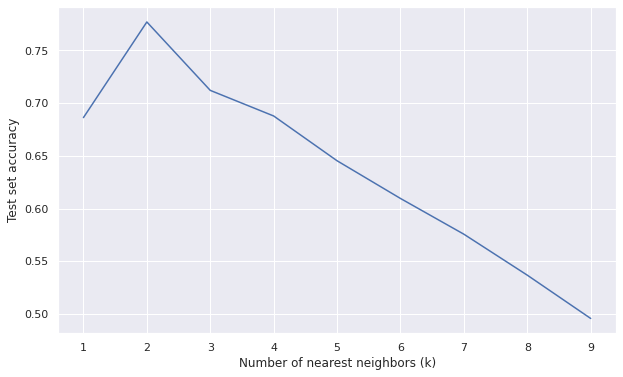

In [42]:
plt.figure(figsize=(10, 6))
plt.plot(list(range(1, 10)), test_scores)
plt.xlabel('Number of nearest neighbors (k)')
plt.ylabel('Test set accuracy')